# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis

##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## High vs low temperature 

In [4]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP.*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [5]:
%%time
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 10.4 s, sys: 15.8 s, total: 26.2 s
Wall time: 1min 1s


In [6]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter,axis=0) # Size (12,180,360)

In [7]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,180,360]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds_inter[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

CPU times: user 569 ms, sys: 422 ms, total: 990 ms
Wall time: 1.04 s


## Calculate the cold vs the warm years for all the latitudes and longitudes.. 
    1. We have the anonmalies for each latitude and longitude
    2. We have the standard error for each latitude and each longitude 
    3. we want to select the warm and cold years from each latitude and each longitude... 

In [8]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
cold_years_arctic = {}
warm_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
cold_years_arctic = multi_dict(2, int)
warm_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        warm_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

## Now make sure that this works and can be used!! 

In [9]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,180,360]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,180,360]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[cold_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[warm_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

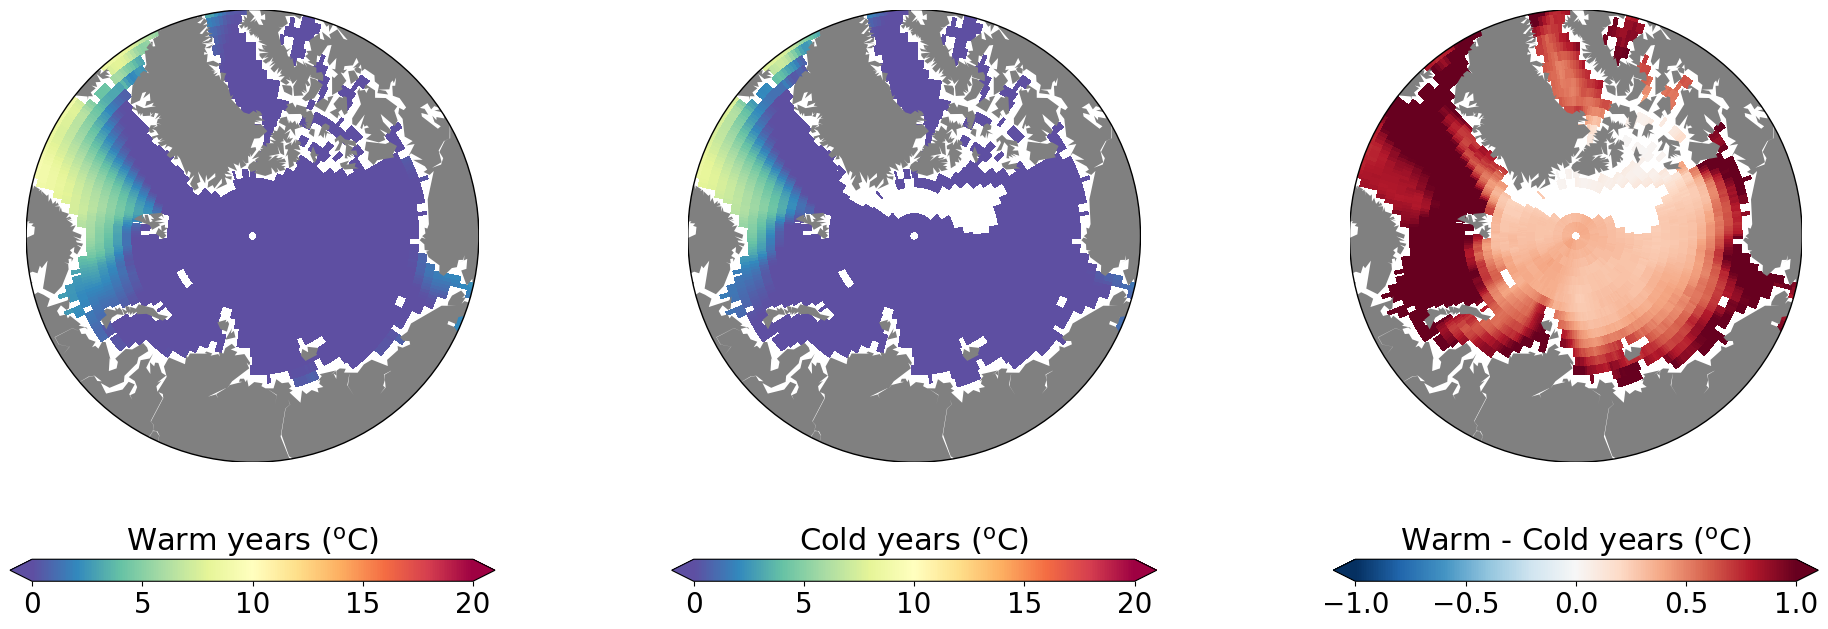

In [10]:
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(cold_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(warm_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm - Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

## Now check Seasonally differences 

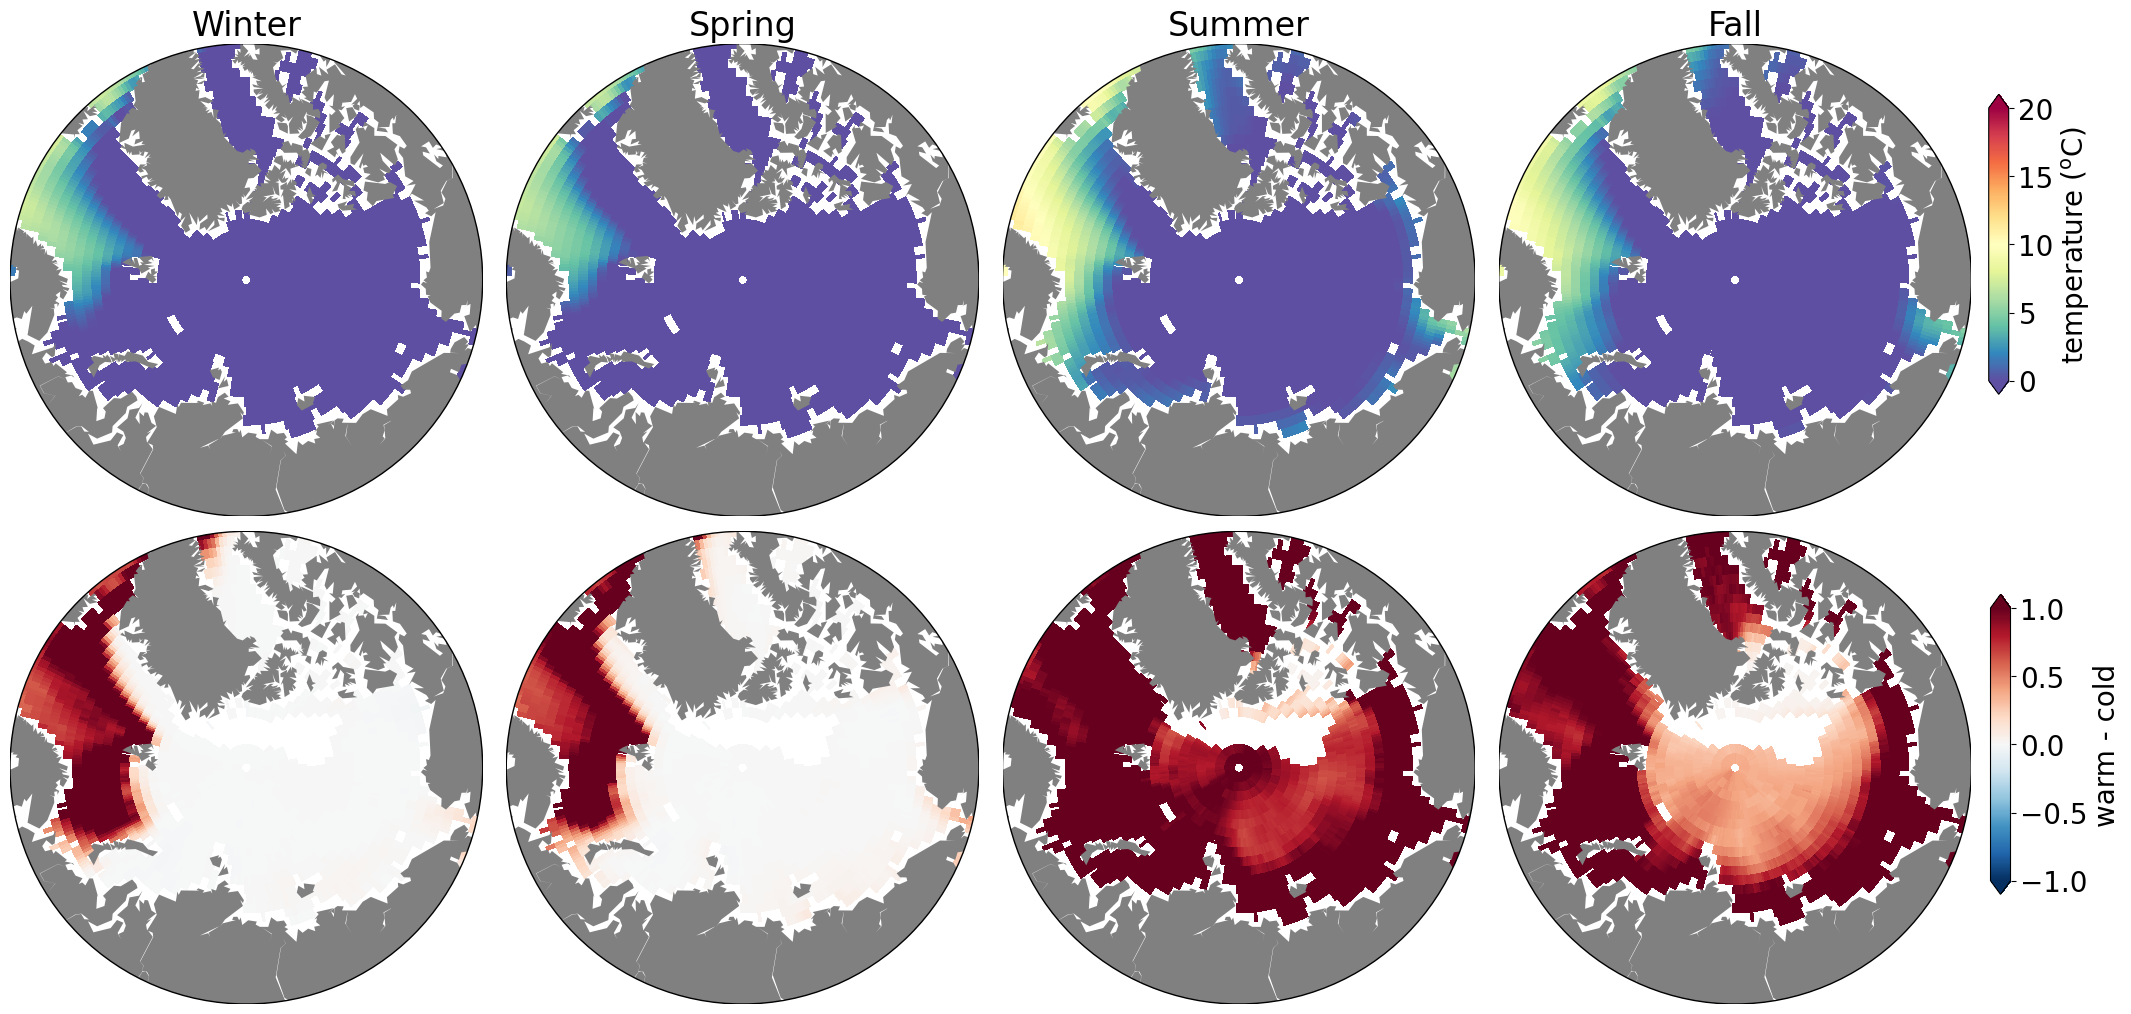

In [11]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('temperature ($^o$C)', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(warm_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(cold_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(warm_years_temp[2:5,:,:], axis=(0))-np.nanmean(cold_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(warm_years_temp[5:8,:,:], axis=(0))-np.nanmean(cold_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(warm_years_temp[8:11,:,:], axis=(0))-np.nanmean(cold_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('warm - cold', fontsize=20)
plt.tight_layout()

## ICE FRACTION

In [12]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [14]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter,axis=0) # Size (12,180,360)

In [15]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,180,360]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds_inter[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

CPU times: user 572 ms, sys: 547 ms, total: 1.12 s
Wall time: 1.16 s


In [16]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [17]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,180,360]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,180,360]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

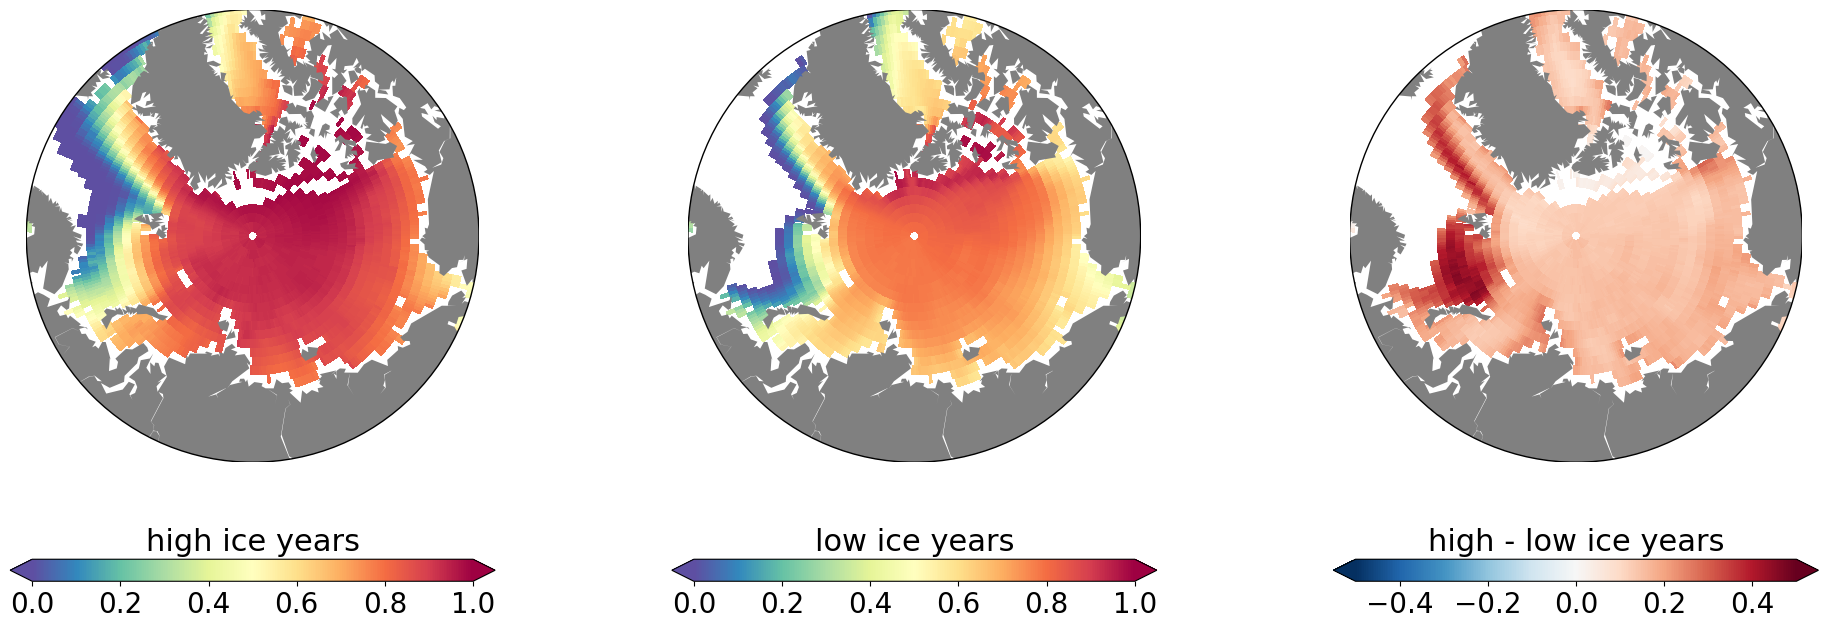

In [18]:
fig = plt.figure(figsize=(20, 20))
lat = ds_02.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -0.5, vmax = 0.5)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

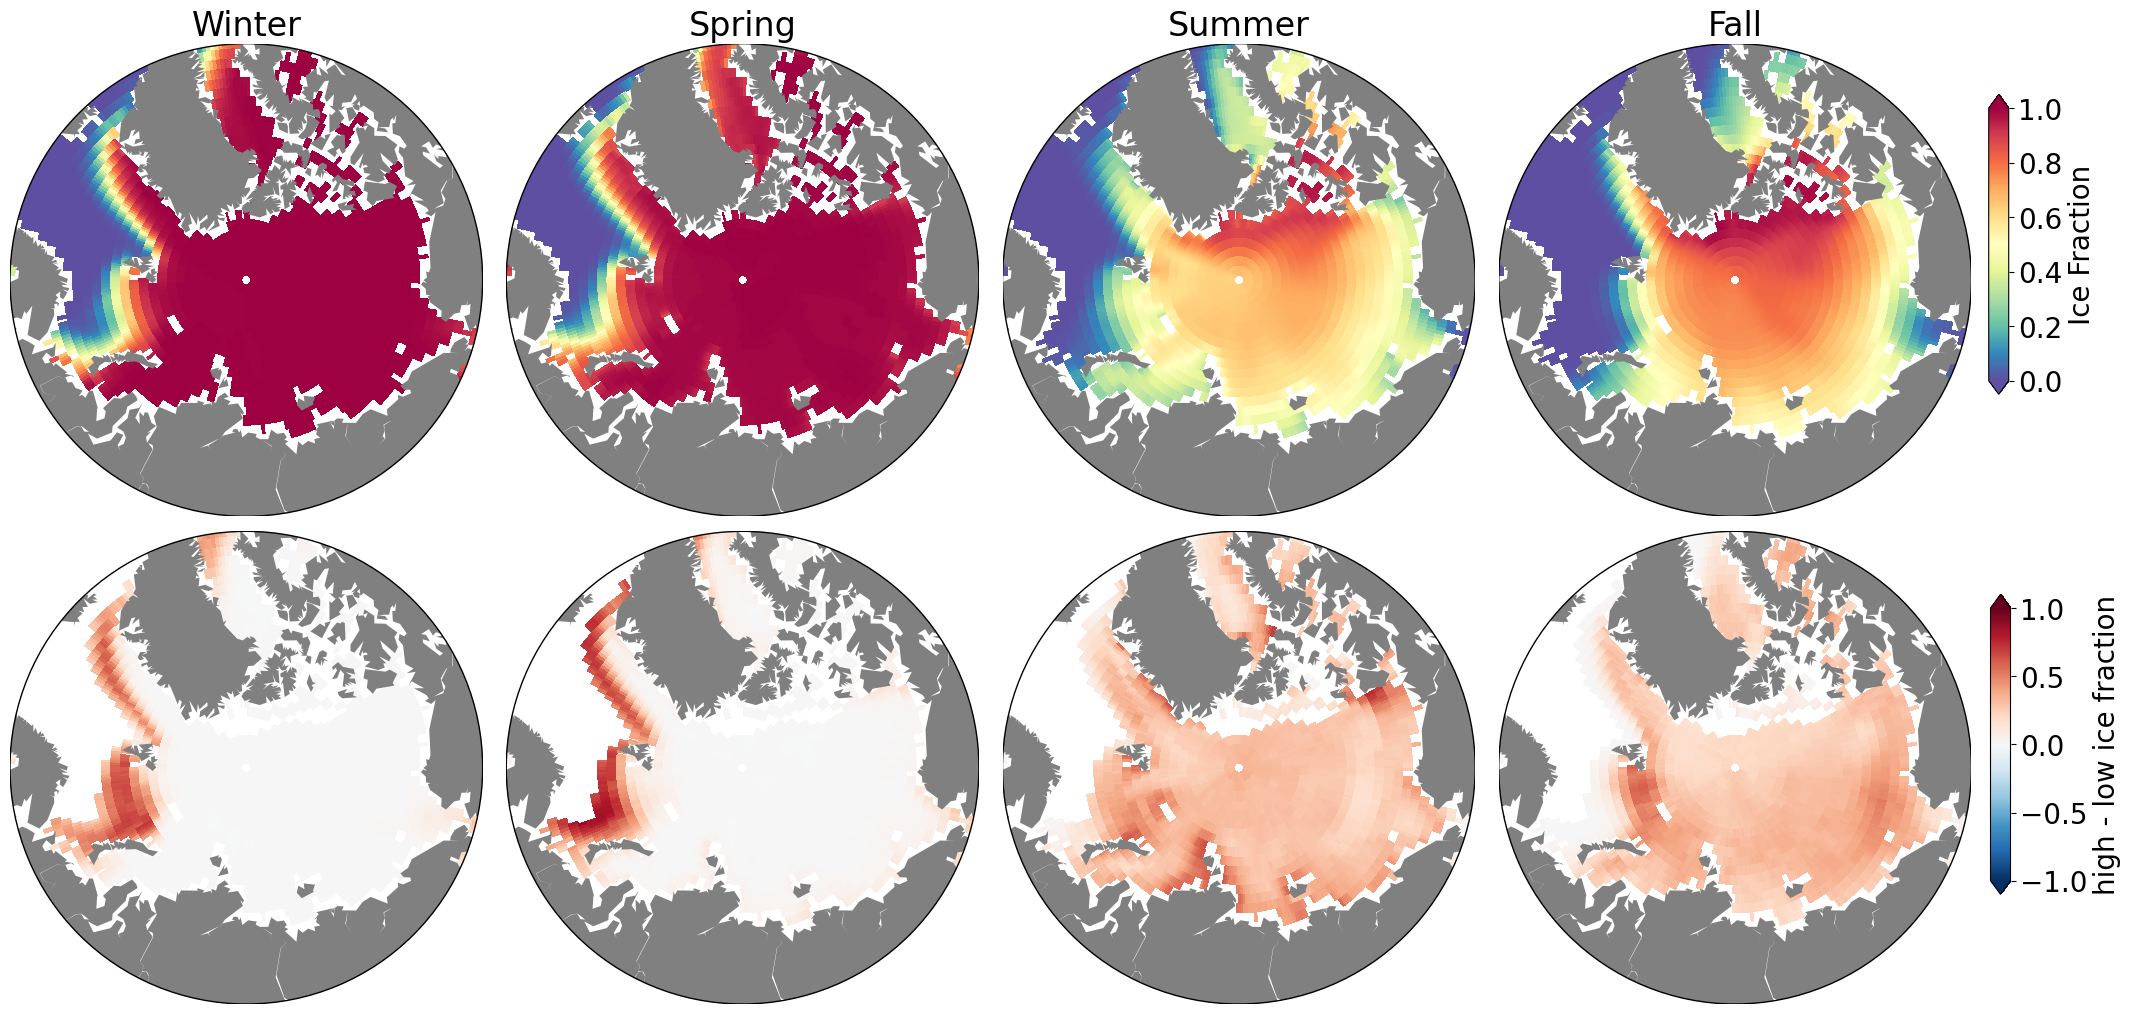

In [19]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('Ice Fraction', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(high_ice_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(low_ice_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(high_ice_years_temp[2:5,:,:], axis=(0))-np.nanmean(low_ice_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(high_ice_years_temp[5:8,:,:], axis=(0))-np.nanmean(low_ice_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(high_ice_years_temp[8:11,:,:], axis=(0))-np.nanmean(low_ice_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('high - low ice fraction', fontsize=20)
plt.tight_layout()

## NO$_3$ Years

In [20]:
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [21]:
%%time
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 10.8 s, sys: 15.4 s, total: 26.2 s
Wall time: 38.1 s


In [22]:
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter,axis=0) # Size (12,180,360)

In [23]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,180,360]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds_inter[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

CPU times: user 578 ms, sys: 447 ms, total: 1.03 s
Wall time: 1.04 s


In [24]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [25]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,180,360]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,180,360]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

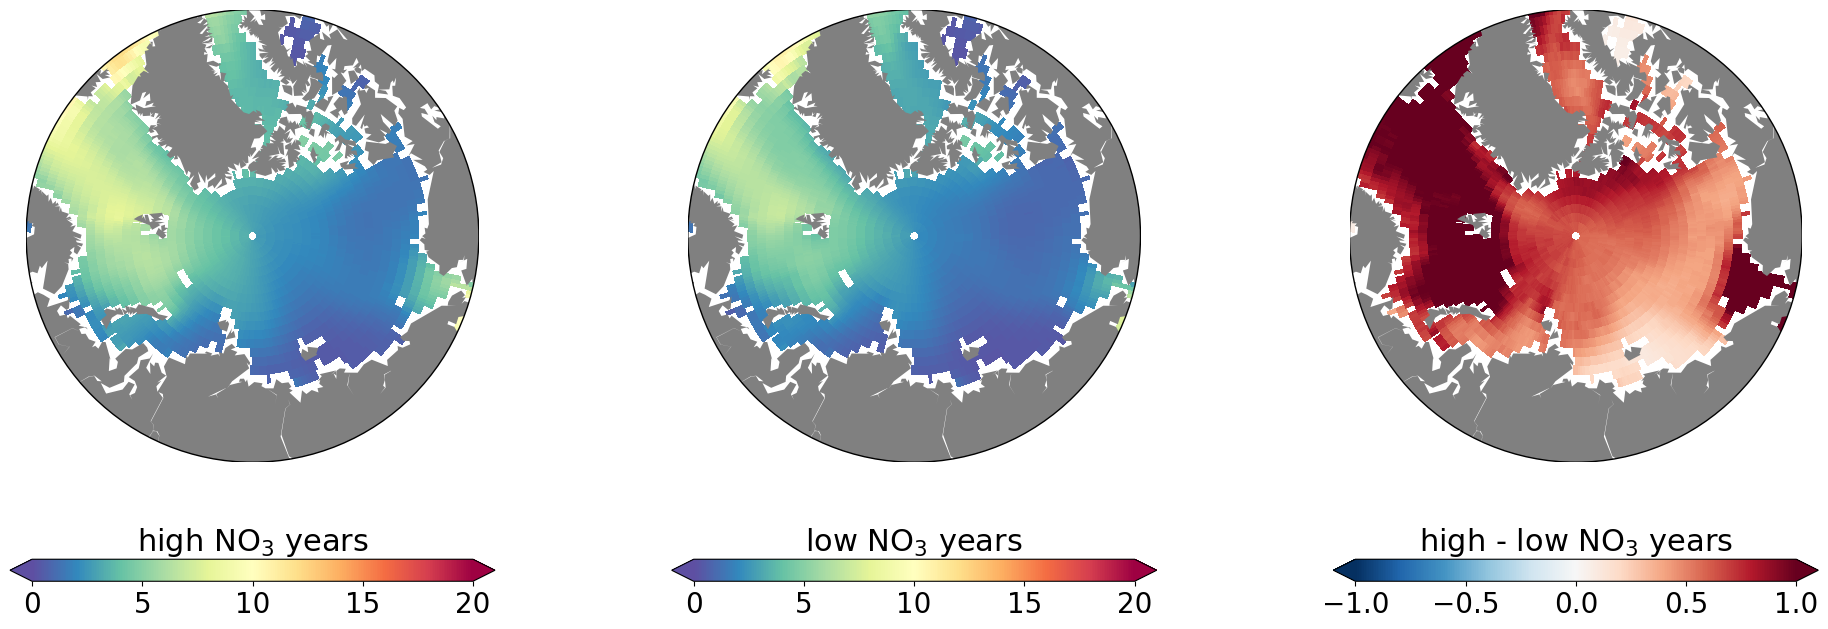

In [26]:
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

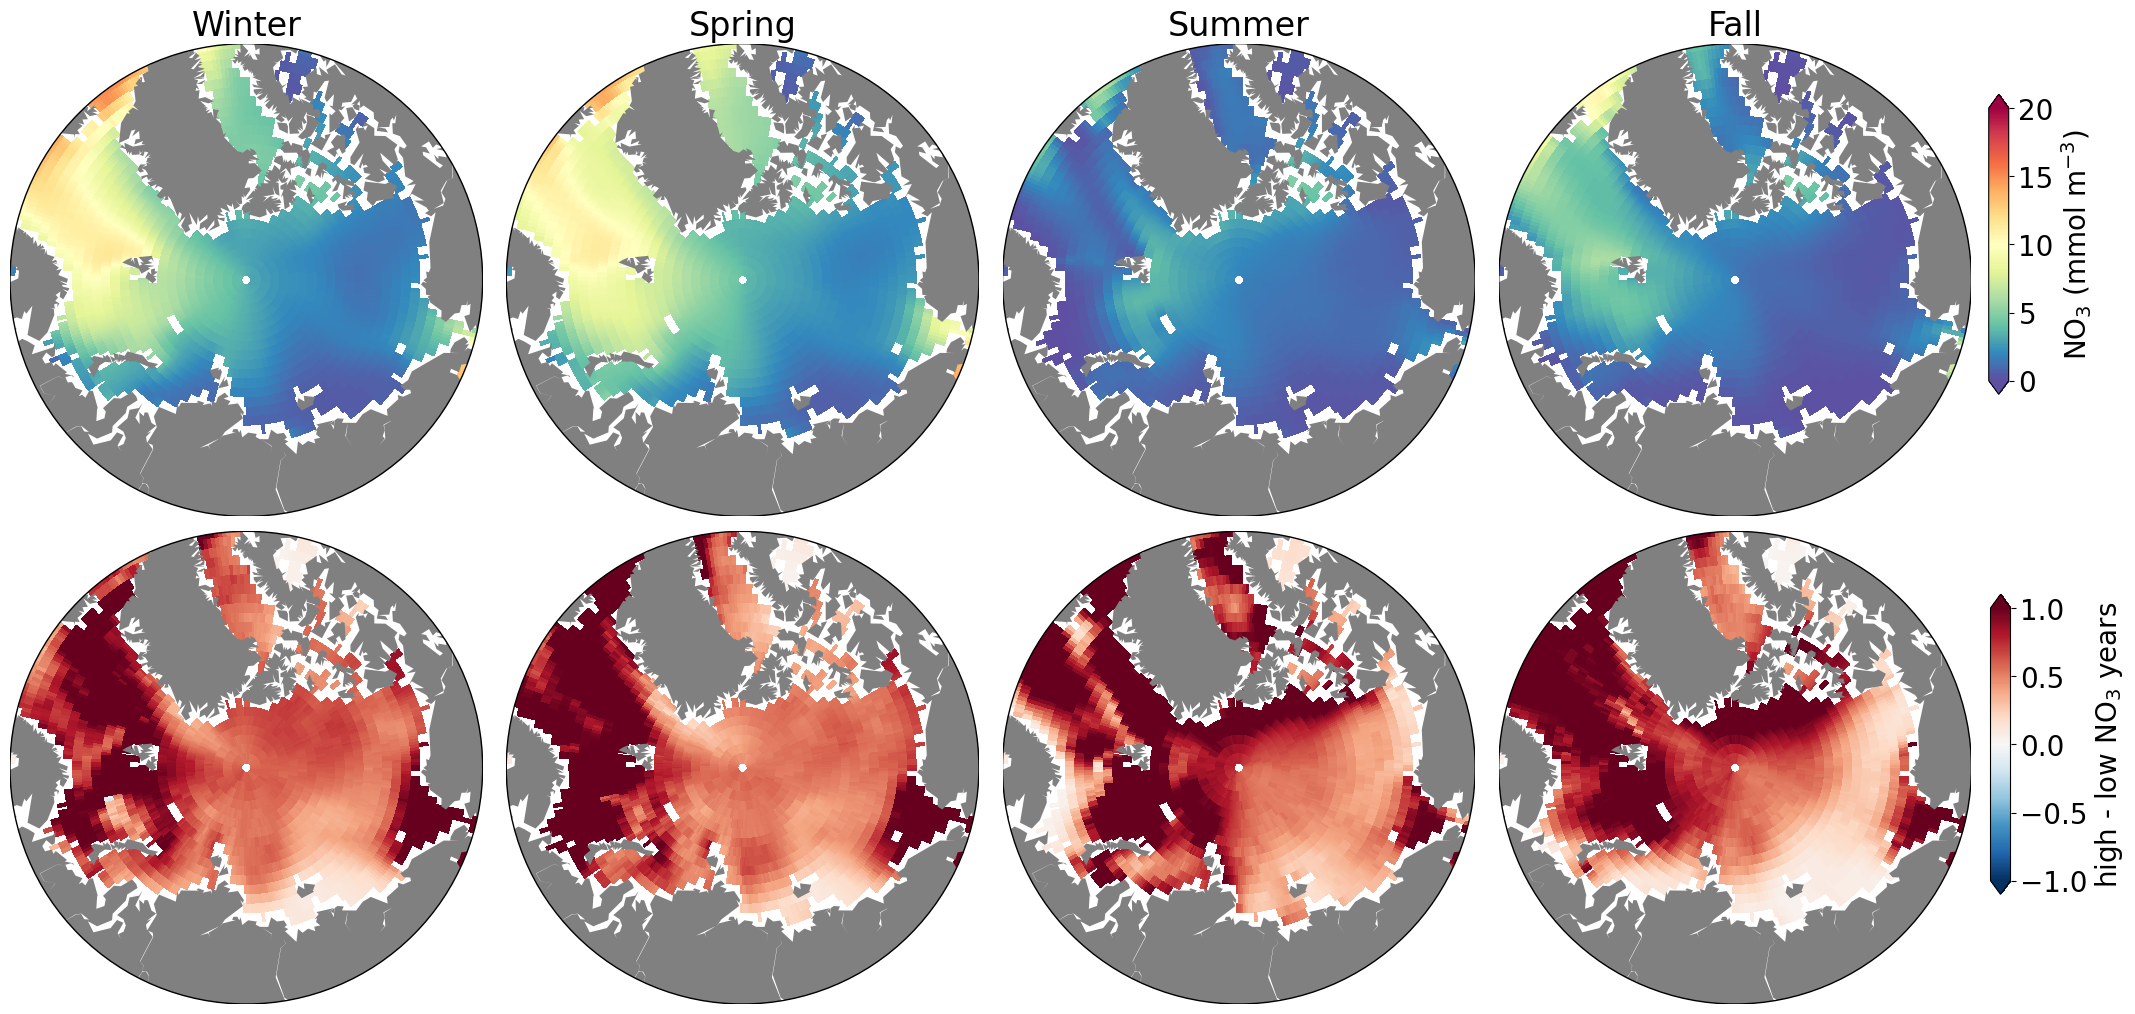

In [27]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(high_no3_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(low_no3_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(high_no3_years_temp[2:5,:,:], axis=(0))-np.nanmean(low_no3_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(high_no3_years_temp[5:8,:,:], axis=(0))-np.nanmean(low_no3_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(high_no3_years_temp[8:11,:,:], axis=(0))-np.nanmean(low_no3_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('high - low NO$_3$ years', fontsize=20)
plt.tight_layout()

## Plot phytoplankton biomass interannually 

In [28]:
file = '/glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/'
ds_spring= xr.open_mfdataset(f'{file}/regrid_spring_phyto_bmss_62yr.nc')
ds_summer= xr.open_mfdataset(f'{file}/regrid_summer_phyto_bmss_62yr.nc')
ds_fall= xr.open_mfdataset(f'{file}/regrid_fall_phyto_bmss_62yr.nc')
ds_winter= xr.open_mfdataset(f'{file}/regrid_winter_phyto_bmss_62yr.nc') # Full 62 years of second cycle regridded

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_phyto_bmss_62yr.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_phyto_bmss_62yr.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset lon
			found dataset lat
			found dataset year
			found dataset phytoC_spring_bm
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x3a0000 ext_ncid 0x3a0000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_phyto_bmss_62yr.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 4 natts: 0
		 DIMENSION - dimid: 0 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 1 name: lat len: 180 unlimited: 0
		 DIMENSION - dimid: 2 name: year len: 62 unlimited: 0
		 VARIABLE - varid: 0 name: lon ndims: 1 dimscale: 1 dimids: 0


In [29]:
ds_spring.phytoC_spring_bm

<xarray.DataArray 'phytoC_spring_bm' (year: 62, lat: 180, lon: 360)>
dask.array<open_dataset-2b272039235c7b6ef2d9382694cd6db7phytoC_spring_bm, shape=(62, 180, 360), dtype=float32, chunksize=(62, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0 61.0

In [30]:
photoC_TOT_spring = np.array(ds_spring.phytoC_spring_bm)
photoC_TOT_summer = np.array(ds_summer.phytoC_summer_bm)
photoC_TOT_fall = np.array(ds_fall.phytoC_fall_bm)
photoC_TOT_winter = np.array(ds_winter.phytoC_winter_bm)

		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_dim: ncid 0x3a0000 dimid 2
		NC4_inq_dim: ncid 0x3a0000 dimid 1
		NC4_inq_dim: ncid 0x3a0000 dimid 0
		NC4_inq_dim: ncid 0x3a0000 dimid 2
		NC4_inq_dim: ncid 0x3a0000 dimid 1
		NC4_inq_dim: ncid 0x3a0000 dimid 0
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_dim: ncid 0x3a0000 dimid 2
		NC4_inq_dim: ncid 0x3a0000 dimid 1
		NC4_inq_dim: ncid 0x3a0000 dimid 0
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_dim: ncid 0x3a0000 dimid 2
		NC4_inq_dim: ncid 0x3a0000 dimid 1
		NC4_inq_dim: ncid 0x3a0000 dimid 0
		NC4_inq_var_all: ncid 0x3a0000 varid 3
			NC4_get_vars: var->hdr.name phytoC_spring_bm mem_nc_type 5
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_var_all: ncid 0x3a0000 varid 3
		NC4_inq_dim: ncid 0x3a0000 dimid 2
		NC4_inq_dim: ncid 0x3a0000 dimid 1
		NC4_inq_dim: ncid 0x3a0000 dimid 0
		NC4_inq_att:

## NO$_3$

In [31]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([180,360]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([180,360]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([180,360]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([180,360]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([180,360]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([180,360]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([180,360]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([180,360]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(photoC_TOT_spring[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(photoC_TOT_spring[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(photoC_TOT_winter[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(photoC_TOT_winter[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.02 s, sys: 2.96 ms, total: 3.02 s
Wall time: 3.1 s


## Temperature 

In [32]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([180,360]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([180,360]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([180,360]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([180,360]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([180,360]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([180,360]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([180,360]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([180,360]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(photoC_TOT_spring[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(photoC_TOT_spring[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(photoC_TOT_winter[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(photoC_TOT_winter[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.14 s, sys: 4.52 ms, total: 3.15 s
Wall time: 3.2 s


## Ice Fraction

In [33]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([180,360]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([180,360]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([180,360]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([180,360]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([180,360]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([180,360]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([180,360]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([180,360]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(photoC_TOT_summer[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(photoC_TOT_spring[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(photoC_TOT_spring[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(photoC_TOT_fall[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(photoC_TOT_winter[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(photoC_TOT_winter[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.39 s, sys: 4.45 ms, total: 3.39 s
Wall time: 3.47 s


## import the ice fraction information

In [34]:
ice_frac_summer = np.nanmean(ECOSYS_IFRAC_ds_inter[:,5:8,:,:],axis=1)
ice_frac_spring = np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,:,:],axis=1)
ice_frac_winter = np.nanmean(ECOSYS_IFRAC_ds_inter[:,list(range(2)) + [-1],:,:],axis=1)
ice_frac_fall = np.nanmean(ECOSYS_IFRAC_ds_inter[:,8:11,:,:],axis=1)

In [35]:
# This is loading the low and high temp, no3 and ice years when averging the whole Arctic... 
# I tried to do it grid by grid, but ice fraction works better when you average throughout the whole Arctic. 
high_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')

high_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')

high_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')
low_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')

In [36]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

In [37]:
ice_frac_summer.shape

(62, 180, 360)

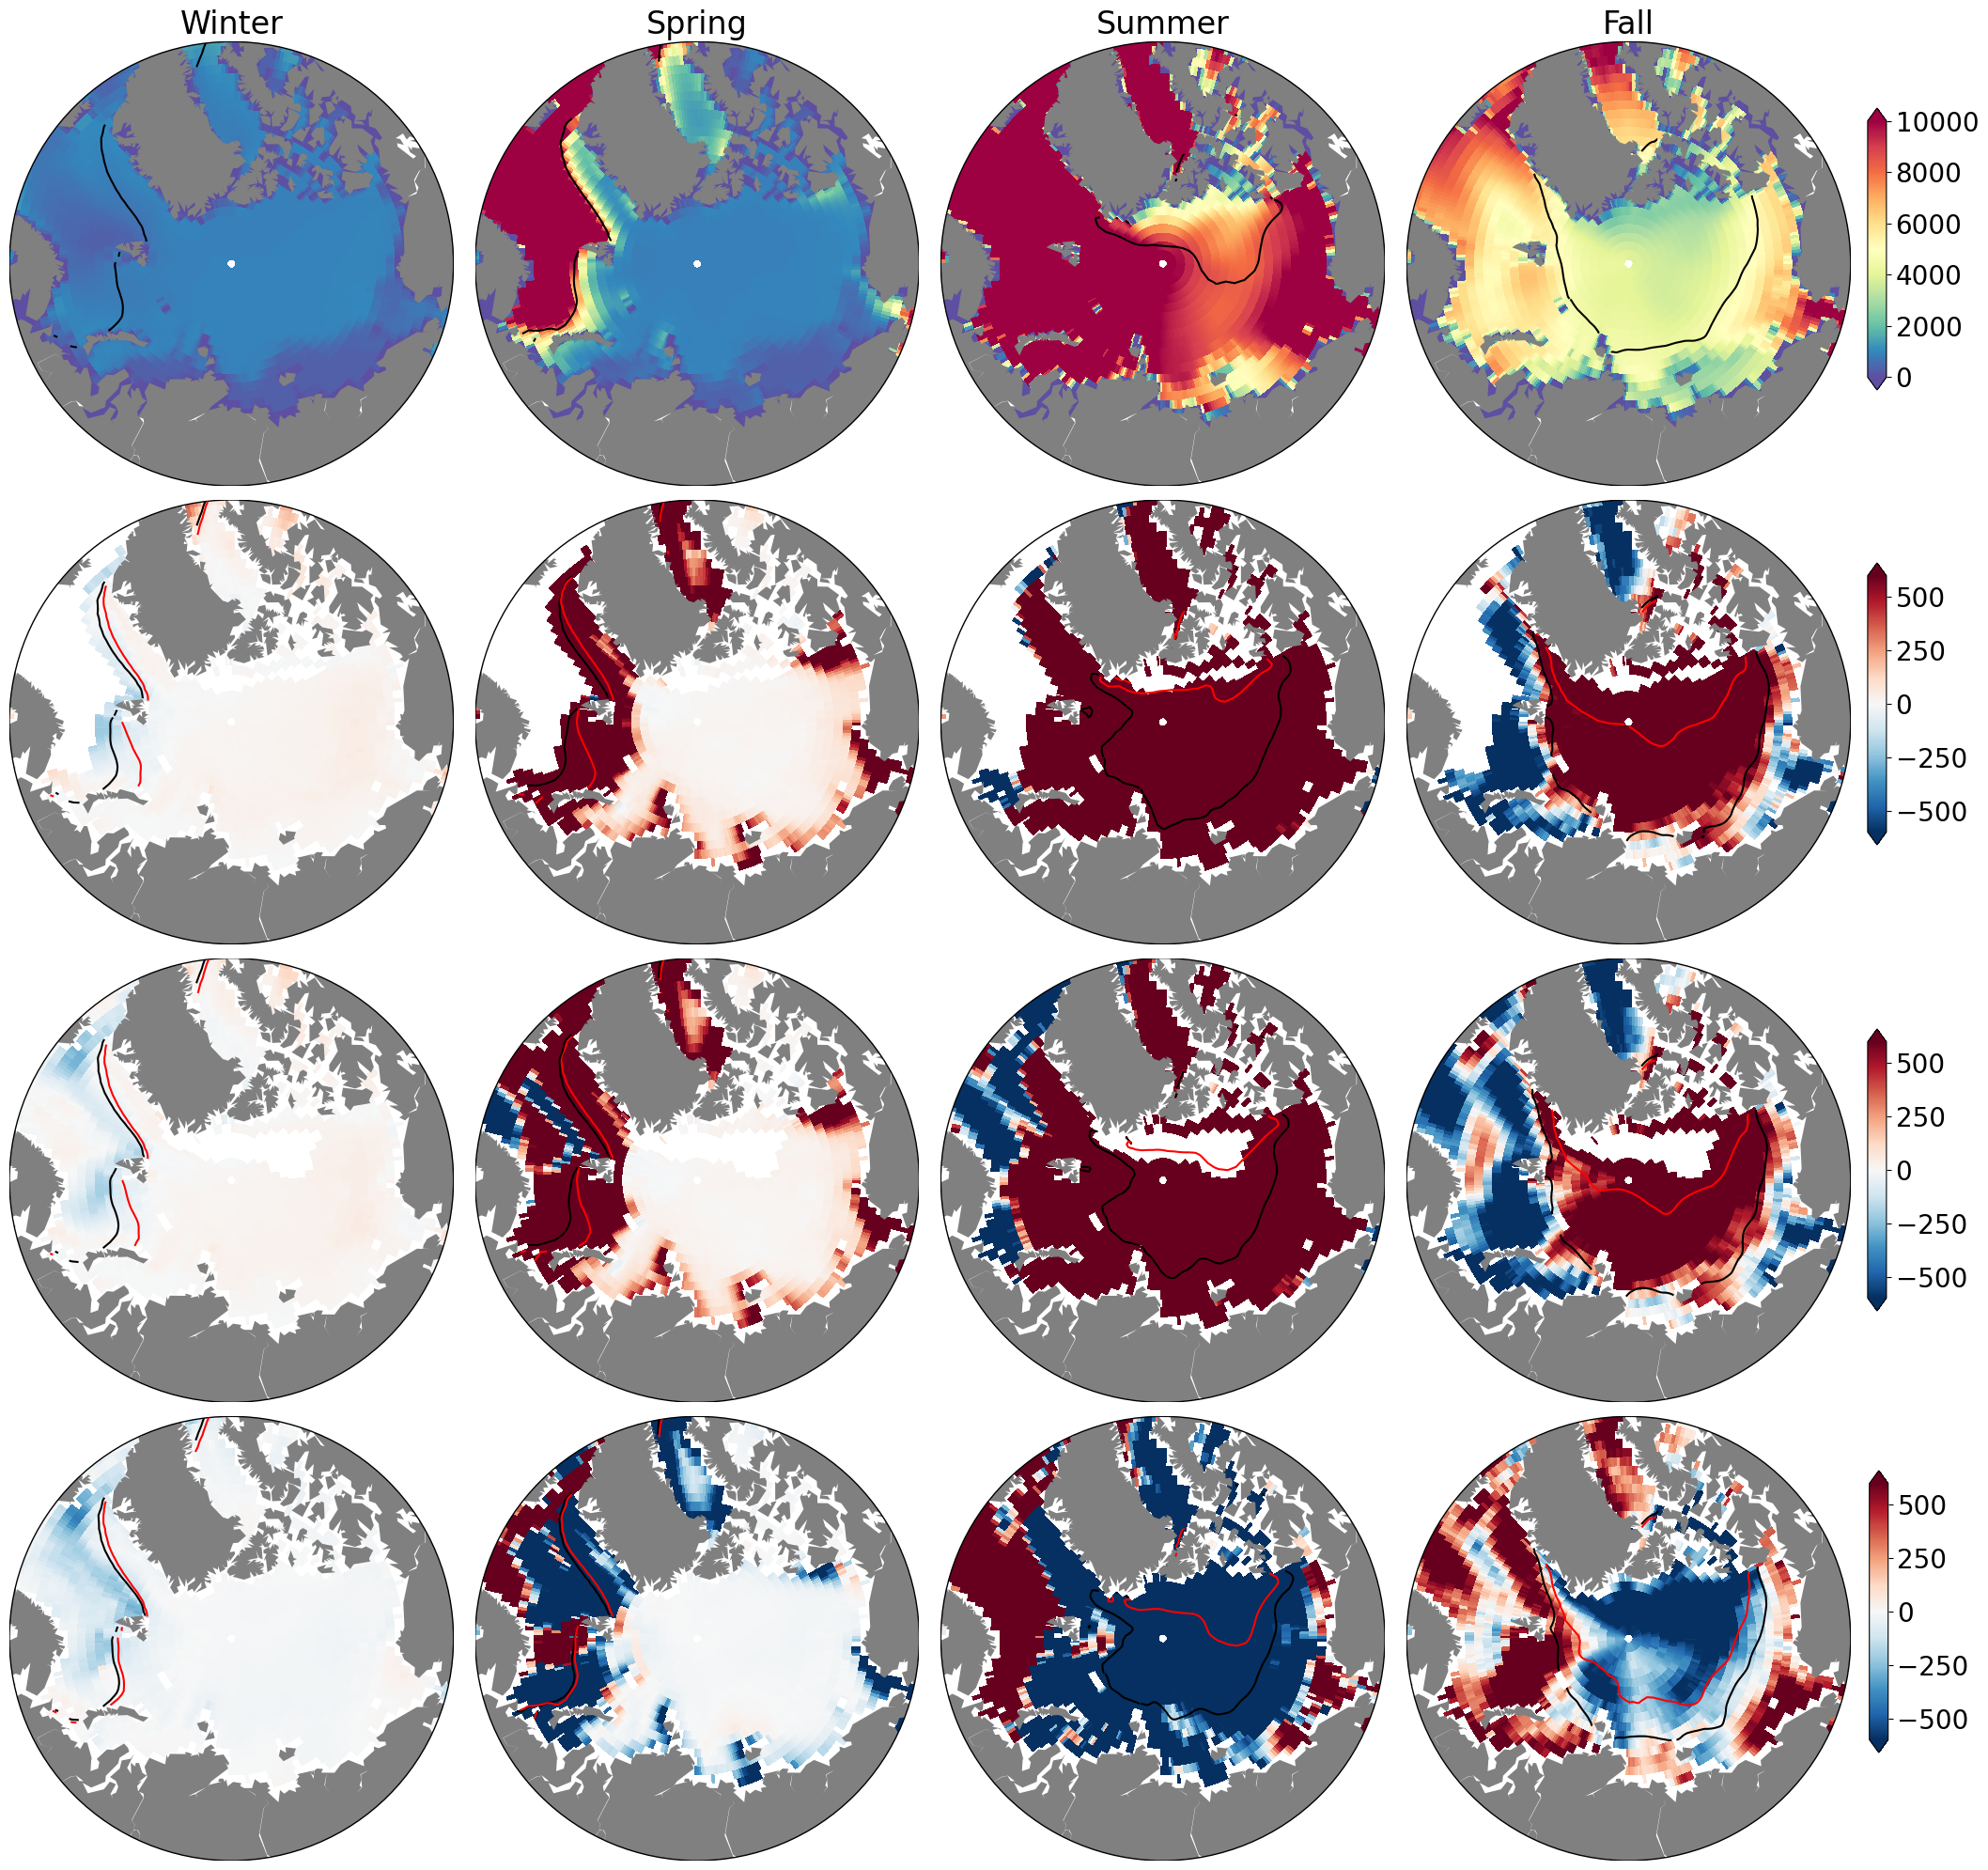

In [38]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

####################### 62 year averages ###############################

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(photoC_TOT_winter,axis=(0)), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
winter_ice, lon = add_cyclic_point(np.nanmean(ice_frac_winter, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(photoC_TOT_spring,axis=(0)), coord=ds_03.lon, axis=1)
spring_ice, lon = add_cyclic_point(np.nanmean(ice_frac_spring, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(photoC_TOT_summer,axis=(0)), coord=ds_03.lon, axis=1)
summer_ice, lon = add_cyclic_point(np.nanmean(ice_frac_summer, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(photoC_TOT_fall,axis=(0)), coord=ds_03.lon, axis=1)
fall_ice, lon = add_cyclic_point(np.nanmean(ice_frac_fall, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

####################### Low - high temperature differences  ###############################
## Set the vmin and vmax values here: ## 
vminn = -600
vmaxx = 600

# WINTER
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
w_diff, lon =  add_cyclic_point(winter_temp_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# SPRING
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
sp_diff, lon =  add_cyclic_point(spring_temp_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# SUMMER
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
s_diff, lon =  add_cyclic_point(summer_temp_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# FALL 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
f_diff, lon =  add_cyclic_point(fall_temp_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (cold-warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)


##################################### Ice Fraction  ###################################
# WINTER
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
w_diff, lon =  add_cyclic_point(winter_ice_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SPRING
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
sp_diff, lon =  add_cyclic_point(spring_ice_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SUMMER
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
s_diff, lon =  add_cyclic_point(summer_ice_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years

# FALL
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
f_diff, lon =  add_cyclic_point(fall_ice_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

######################## NO3 ###################################

# WINTER
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
w_diff, lon =  add_cyclic_point(winter_no3_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SPRING
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
sp_diff, lon =  add_cyclic_point(spring_no3_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SUMMER. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
s_diff, lon =  add_cyclic_point(summer_no3_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# FALL
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
f_diff, lon =  add_cyclic_point(fall_no3_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_phytoplankton_biomass_quarterly_interannual_diff_1deg.png',dpi=600, bbox_inches='tight')

## Load zooplankton biomass 

In [40]:
file = '/glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid'
ds_spring= xr.open_mfdataset(f'{file}/regrid_spring_zoo_bmss_62yr.nc')
ds_summer= xr.open_mfdataset(f'{file}/regrid_summer_zoo_bmss_62yr.nc')
ds_fall= xr.open_mfdataset(f'{file}/regrid_fall_zoo_bmss_62yr.nc')
ds_winter= xr.open_mfdataset(f'{file}/regrid_winter_zoo_bmss_62yr.nc') # Full 62 years of second cycle regridded

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_zoo_bmss_62yr.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_zoo_bmss_62yr.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset lon
			found dataset lat
			found dataset year
			found dataset zooC_spring_bm
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x3e0000 ext_ncid 0x3e0000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid/regrid_spring_zoo_bmss_62yr.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 4 natts: 0
		 DIMENSION - dimid: 0 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 1 name: lat len: 180 unlimited: 0
		 DIMENSION - dimid: 2 name: year len: 62 unlimited: 0
		 VARIABLE - varid: 0 name: lon ndims: 1 dimscale: 1 dimids: 0
		 VARIA

In [41]:
ds_fall

<xarray.Dataset>
Dimensions:       (lon: 360, lat: 180, year: 62)
Coordinates:
  * lon           (lon) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * year          (year) float64 0.0 1.0 2.0 3.0 4.0 ... 58.0 59.0 60.0 61.0
Data variables:
    zooC_fall_bm  (year, lat, lon) float32 dask.array<chunksize=(62, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 5.0.3 (Homepage = http://nco.sf.ne...
    history:      Thu Mar 02 16:21:44 2023: cdo sellonlatbox,-180,180,-89.5,8...
    CDO:          Climate Data Operators version 2.0.1 (https://mpimet.mpg.de...

In [42]:
zoo_spring = np.array(ds_spring.zooC_spring_bm)
zoo_summer = np.array(ds_summer.zooC_summer_bm)
zoo_fall = np.array(ds_fall.zooC_fall_bm)
zoo_winter = np.array(ds_winter.zooC_winter_bm)

		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_dim: ncid 0x3e0000 dimid 2
		NC4_inq_dim: ncid 0x3e0000 dimid 1
		NC4_inq_dim: ncid 0x3e0000 dimid 0
		NC4_inq_dim: ncid 0x3e0000 dimid 2
		NC4_inq_dim: ncid 0x3e0000 dimid 1
		NC4_inq_dim: ncid 0x3e0000 dimid 0
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_dim: ncid 0x3e0000 dimid 2
		NC4_inq_dim: ncid 0x3e0000 dimid 1
		NC4_inq_dim: ncid 0x3e0000 dimid 0
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_dim: ncid 0x3e0000 dimid 2
		NC4_inq_dim: ncid 0x3e0000 dimid 1
		NC4_inq_dim: ncid 0x3e0000 dimid 0
		NC4_inq_var_all: ncid 0x3e0000 varid 3
			NC4_get_vars: var->hdr.name zooC_spring_bm mem_nc_type 5
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_var_all: ncid 0x3e0000 varid 3
		NC4_inq_dim: ncid 0x3e0000 dimid 2
		NC4_inq_dim: ncid 0x3e0000 dimid 1
		NC4_inq_dim: ncid 0x3e0000 dimid 0
		NC4_inq_att: n

## Zoo NO$_3$

In [43]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([180,360]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([180,360]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([180,360]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([180,360]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([180,360]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([180,360]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([180,360]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([180,360]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(zoo_summer[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(zoo_summer[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(zoo_spring[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(zoo_spring[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(zoo_fall[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(zoo_fall[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(zoo_winter[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(zoo_winter[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.14 s, sys: 1.93 ms, total: 3.14 s
Wall time: 7.25 s


## Zoo Temperature

In [44]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([180,360]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([180,360]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([180,360]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([180,360]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([180,360]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([180,360]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([180,360]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([180,360]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(zoo_summer[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(zoo_summer[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(zoo_spring[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(zoo_spring[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(zoo_fall[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(zoo_fall[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(zoo_winter[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(zoo_winter[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.13 s, sys: 0 ns, total: 3.13 s
Wall time: 8.29 s


## Zoo Ice Fraction

In [45]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([180,360]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([180,360]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([180,360]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([180,360]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([180,360]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([180,360]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([180,360]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([180,360]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(zoo_summer[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(zoo_summer[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(zoo_spring[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(zoo_spring[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(zoo_fall[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(zoo_fall[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(zoo_winter[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(zoo_winter[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 3.16 s, sys: 0 ns, total: 3.16 s
Wall time: 9.56 s


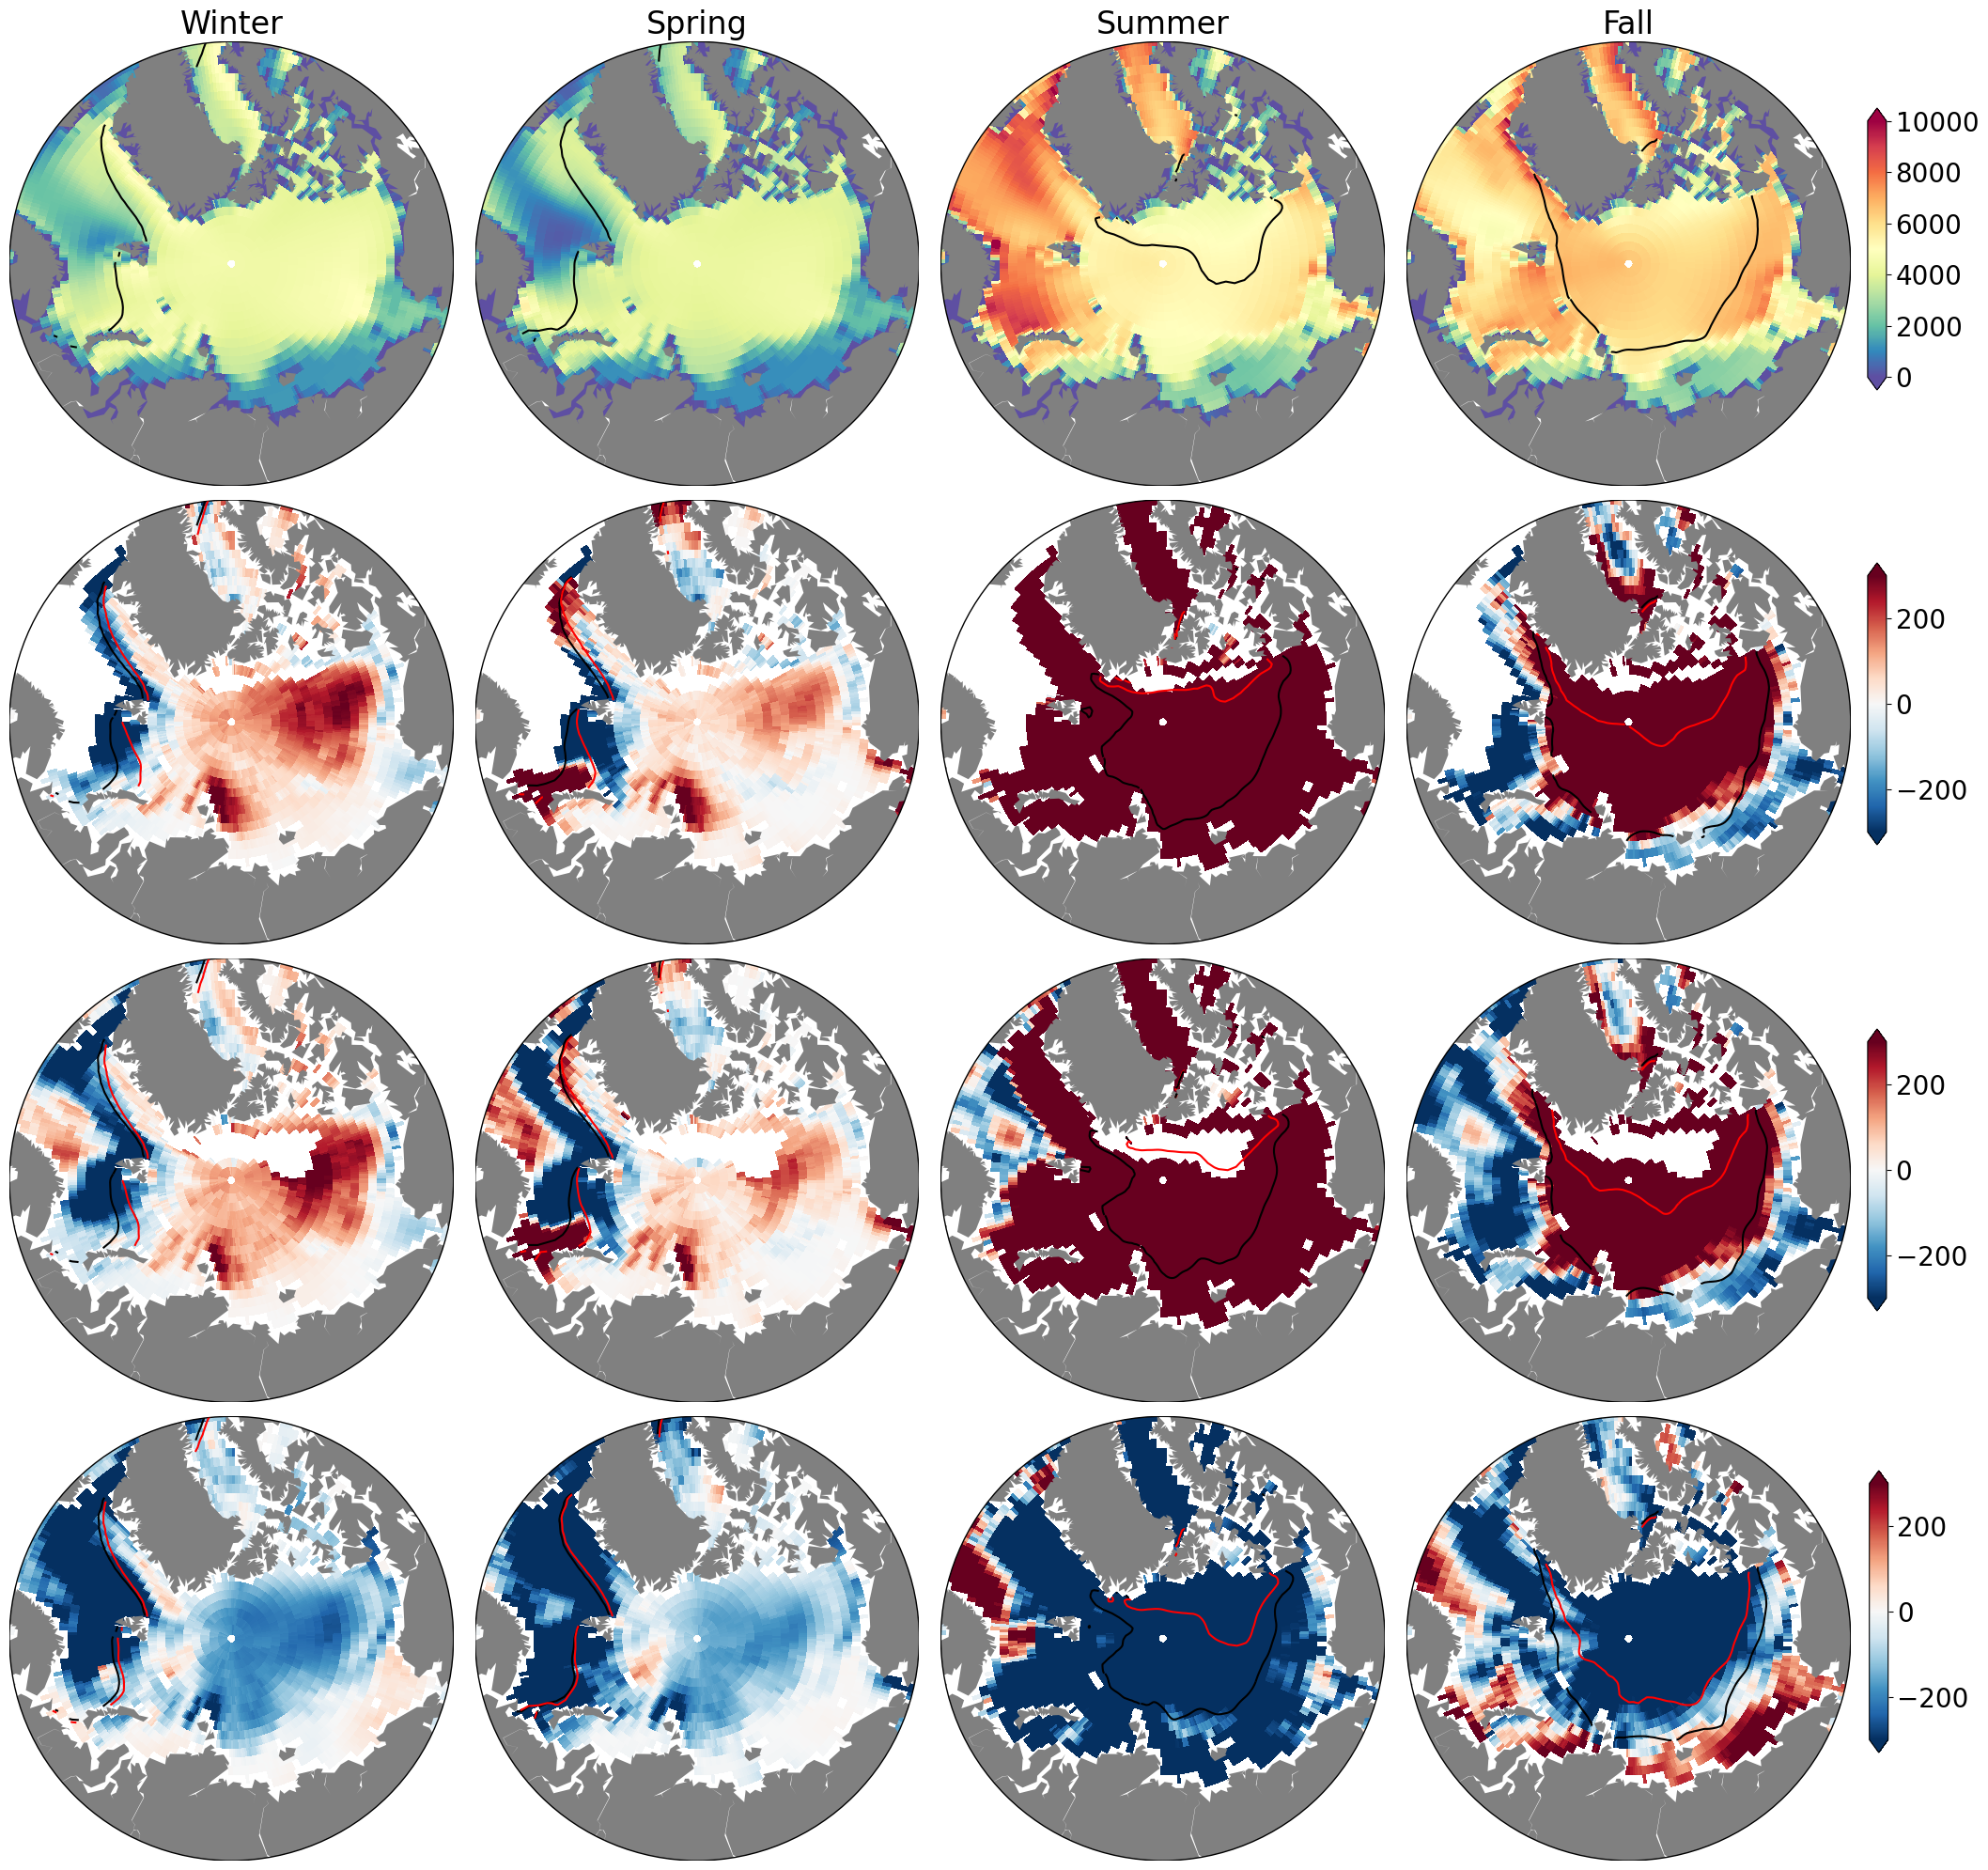

In [47]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

####################### 62 year averages ###############################

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(zoo_winter,axis=(0)), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
winter_ice, lon = add_cyclic_point(np.nanmean(ice_frac_winter, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(zoo_spring,axis=(0)), coord=ds_03.lon, axis=1)
spring_ice, lon = add_cyclic_point(np.nanmean(ice_frac_spring, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(zoo_summer,axis=(0)), coord=ds_03.lon, axis=1)
summer_ice, lon = add_cyclic_point(np.nanmean(ice_frac_summer, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(zoo_fall,axis=(0)), coord=ds_03.lon, axis=1)
fall_ice, lon = add_cyclic_point(np.nanmean(ice_frac_fall, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

####################### Low - high temperature differences  ###############################
## Set the vmin and vmax values here: ## 
vminn = -300
vmaxx = 300

# WINTER
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
w_diff, lon =  add_cyclic_point(winter_temp_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# SPRING
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
sp_diff, lon =  add_cyclic_point(spring_temp_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# SUMMER
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
s_diff, lon =  add_cyclic_point(summer_temp_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# FALL 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
f_diff, lon =  add_cyclic_point(fall_temp_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (cold-warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)


##################################### Ice Fraction  ###################################
# WINTER
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
w_diff, lon =  add_cyclic_point(winter_ice_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SPRING
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
sp_diff, lon =  add_cyclic_point(spring_ice_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SUMMER
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
s_diff, lon =  add_cyclic_point(summer_ice_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years

# FALL
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
f_diff, lon =  add_cyclic_point(fall_ice_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

######################## NO3 ###################################

# WINTER
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
w_diff, lon =  add_cyclic_point(winter_no3_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SPRING
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
sp_diff, lon =  add_cyclic_point(spring_no3_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SUMMER. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
s_diff, lon =  add_cyclic_point(summer_no3_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# FALL
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
f_diff, lon =  add_cyclic_point(fall_no3_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_zooplankton_biomass_quarterly_interannual_diff_1deg.png',dpi=600, bbox_inches='tight')